# Updraft/downdraft ensembles

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import sys
import random

import metpy.calc as mpcalc
from metpy.units import units, concatenate

from dparcel.thermo import (saturation_specific_humidity,
                            equivalent_potential_temperature)
sys.path.append('../convection_scheme')
from coupler import Coupler
from thermal_generator import ThermalGenerator

## Singapore

In [139]:
file = ('test_soundings/48698 WSSS Singapore Observations '
        'at 00Z 01 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
height -= height[-1]
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
coupler = Coupler(pressure, height, temperature, specific_humidity)

### No drag

In [140]:
# updraft parameters
i_init = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.05)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [141]:
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts1 = np.zeros(epsilon.size, dtype='object')
downdrafts2 = np.zeros(epsilon.size, dtype='object')
downdrafts3 = np.zeros(epsilon.size, dtype='object')
n_done = 0
for i in range(epsilon.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {epsilon.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

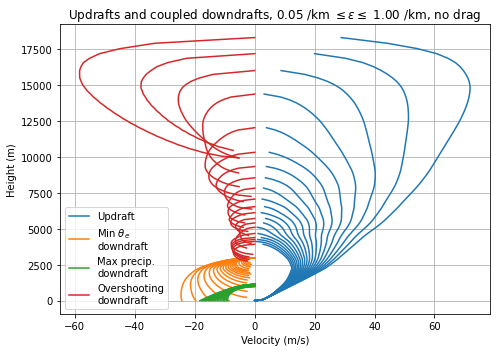

In [142]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '0.05 /km $\\leq \\epsilon \\leq$ 1.00 /km, no drag')
fig.tight_layout()

### With drag

In [143]:
# updraft parameters
i_init = pressure.size - 1
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.05)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0.5/units.km

In [144]:
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts1 = np.zeros(epsilon.size, dtype='object')
downdrafts2 = np.zeros(epsilon.size, dtype='object')
downdrafts3 = np.zeros(epsilon.size, dtype='object')
n_done = 0
for i in range(epsilon.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {epsilon.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

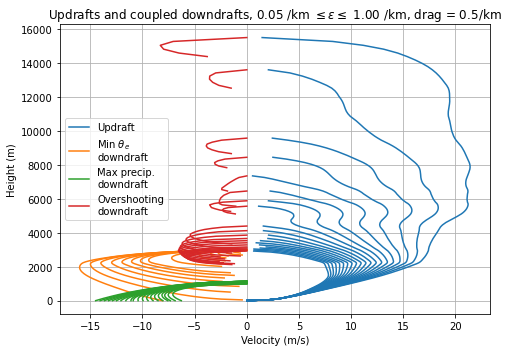

In [145]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '0.05 /km $\\leq \\epsilon \\leq$ 1.00 /km, drag = 0.5/km')
fig.tight_layout()

## Williamtown

In [146]:
file = ('test_soundings/94776 YSWM Williamtown Amo Raaf Observations '
        'at 00Z 21 Dec 2021.txt')
sounding = pd.read_fwf(file, usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure_raw = sounding[:2:-1,0]
height_raw = sounding[:2:-1,1]
temperature_raw = sounding[:2:-1,2]
dewpoint_raw = sounding[:2:-1,3]

pressure = np.arange(pressure_raw[0], pressure_raw[-1], 5)*units.mbar
height = interp1d(pressure_raw, height_raw)(pressure)*units.meter
height -= height[-1]
temperature = interp1d(pressure_raw, temperature_raw)(pressure)*units.celsius
dewpoint = interp1d(pressure_raw, dewpoint_raw)(pressure)*units.celsius
specific_humidity = mpcalc.specific_humidity_from_dewpoint(pressure, dewpoint)
coupler = Coupler(pressure, height, temperature, specific_humidity)

### No drag

In [147]:
# updraft parameters
i_init = np.argmin(np.abs(pressure - 900*units.mbar))
t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.05)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0/units.km

In [148]:
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts1 = np.zeros(epsilon.size, dtype='object')
downdrafts2 = np.zeros(epsilon.size, dtype='object')
downdrafts3 = np.zeros(epsilon.size, dtype='object')
n_done = 0
for i in range(epsilon.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {epsilon.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

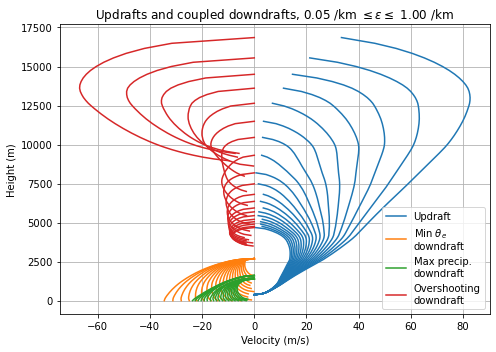

In [149]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '0.05 /km $\\leq \\epsilon \\leq$ 1.00 /km')
fig.tight_layout()

### With drag

In [150]:
# updraft parameters
i_init = np.argmin(np.abs(pressure - 900*units.mbar))

t_pert = 1.0*units.delta_degC
q_pert = (
    saturation_specific_humidity(pressure[i_init], temperature[i_init])
     - specific_humidity[i_init]
)
l_initial = 0*units.dimensionless
l_crit = 2.0e-3*units.dimensionless

# shared parameters
w_initial = 0*units.meter/units.second
epsilon = np.arange(0.05, 1.01, 0.05)*(1/units.km)
dnu_db = 5e-2*units.second**2/units.meter**2
drag = 0.5/units.km

In [151]:
updrafts = np.zeros(epsilon.size, dtype='object')
downdrafts1 = np.zeros(epsilon.size, dtype='object')
downdrafts2 = np.zeros(epsilon.size, dtype='object')
downdrafts3 = np.zeros(epsilon.size, dtype='object')
n_done = 0
for i in range(epsilon.size):
    n_done += 1
    sys.stdout.write(f'\rCalculation {n_done} of {epsilon.size}    ')
    updrafts[i], downdrafts1[i], downdrafts2[i] = coupler.precipitation_driven(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)
    _, downdrafts3[i] = coupler.overshooting(
        i_init, t_pert, q_pert, l_initial, w_initial,
        epsilon[i], dnu_db, drag, l_crit, basic=True)

Calculation 20 of 20    

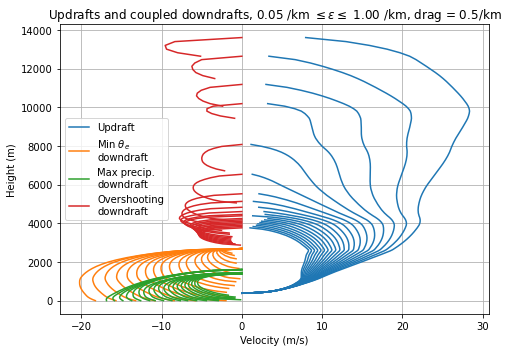

In [152]:
fig, ax = plt.subplots(figsize=(7,5))
lines = ax.plot(
    concatenate([[u.velocity] for u in updrafts]).T, height,
    'tab:blue', label='Updraft')
plt.setp(lines[1:], label="_")
downdrafts1_filt = []
for d in downdrafts1:
    if d is not None:
        downdrafts1_filt.append(d)
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts1_filt]).T, height,
    'tab:orange', label='Min $\\theta_e$\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts2]).T, height,
    'tab:green', label='Max precip.\ndowndraft')
plt.setp(lines[1:], label="_")
lines = ax.plot(
    concatenate([[d.velocity] for d in downdrafts3]).T, height,
    'tab:red', label='Overshooting\ndowndraft')
plt.setp(lines[1:], label="_")
ax.grid()
ax.legend()
ax.set(
    xlabel='Velocity (m/s)', ylabel='Height (m)',
    title='Updrafts and coupled downdrafts, '
          '0.05 /km $\\leq \\epsilon \\leq$ 1.00 /km, drag = 0.5/km')
fig.tight_layout()

## Discussion
- With the addition of overshooting downdrafts, the ensemble results support the conclusions of Torri and Kuang (2016): "although there are downdrafts at all heights, they do not travel much farther than a few hundred meters"
- The precipitation-driven downdrafts are stronger than the overshooting ones
- The addition of drag can reduce velocities to much more realistic values
    - This is consistent with the results of Romps and Charn (2015), who found that the dominant balance in a thermal's momentum budget is between buoyancy and drag (perturbation pressure gradient forces), i.e., thermals are "sticky" rather than "slippery".
    - Without drag, under the assumption that downdrafts have the same entrainment rate as the updrafts that caused them, overshooting downdrafts from weakly entraining updrafts can attain unrealistically high velocities. With drag, all the overshooting downdrafts attain similar, smaller, speeds.